# Prepare the libraries

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore')
sys.path.append("../")

from kats.consts import TimeSeriesData

try: # If running on Jupyter
    air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")
except FileNotFoundError: # If running on colab
    air_passengers_df = pd.read_csv("air_passengers.csv")

# Note: If the column holding the time values is not called time, you will want to specify the name of this column.
air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)

First we are going to do simple forecasting and save the values. Later we are going to do ensemble forecasting.
We see that the median used to get ensemble_mean are the python function, so we proof its behavior.

In [6]:
import statistics
print(statistics.median([1, 3, 5, 7, 9, 11, 13]))

print(statistics.median([1, 3, 5, 9, 11, 13]))  # Te hace la media de los dos de enmedio
print(statistics.median([0, 1, 4, 9, 11, 13])) 

7
7.0
6.5


How to get a covariance?

In [5]:
import numpy as np
x = [-2.1, -1,  4.3]
y = [3,  1.1,  0.12]

np.cov(x,y)[0,1]
np.cov(x,y)

array([[11.71      , -4.286     ],
       [-4.286     ,  2.14413333]])

# The first version of Bates & Granger, it works?

In [9]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima,
    linear_model,
    quadratic_model,
    sarima,
    theta,
)

# we need define params for each individual forecasting model in `EnsembleParams` class
# here we include 5 different models
model_params = EnsembleParams(
            [
                BaseModelParams("arima", arima.ARIMAParams(p=1, d=1, q=1)),
                BaseModelParams(
                    "sarima",
                    sarima.SARIMAParams(
                        p=2,
                        d=1,
                        q=1,
                        trend="ct",
                        seasonal_order=(1, 0, 1, 12),
                        enforce_invertibility=False,
                        enforce_stationarity=False,
                    ),
                ),
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
                BaseModelParams("theta", theta.ThetaParams(m=12)),
            ]
        )

# Forecast with median ensemble vs Bates & Granger ensemble

## Median ensemble

<AxesSubplot: xlabel='time', ylabel='y'>

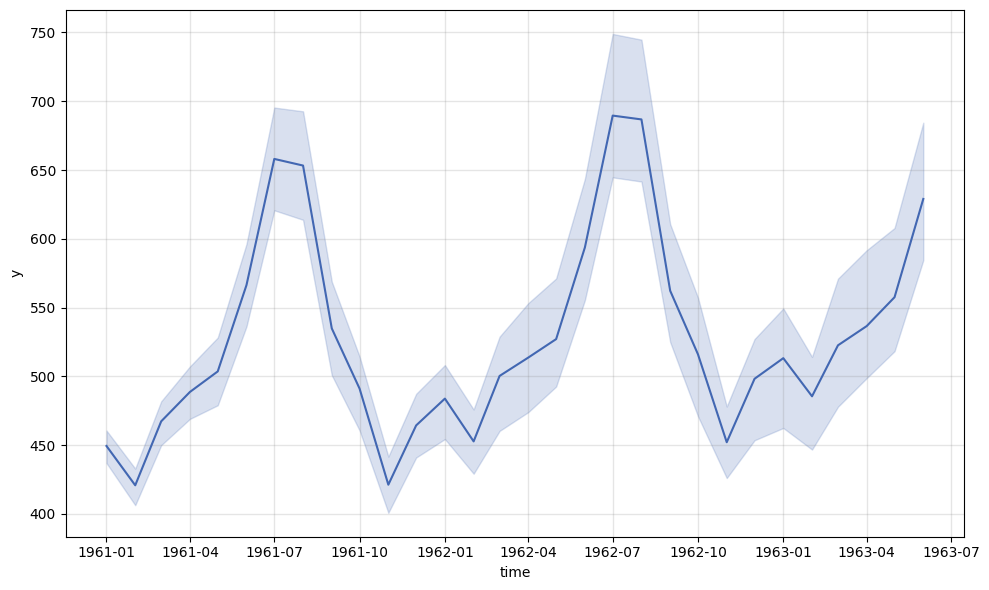

In [10]:
# create `KatsEnsembleParam` with detailed configurations 
KatsEnsembleParamM = {
    "models": model_params,
    "aggregation": "median",
    "seasonality_length": 12,
    "decomposition_method": "multiplicative",
}

# create `KatsEnsemble` model
mM= KatsEnsemble(
    data=air_passengers_ts, 
    params=KatsEnsembleParamM
    )

# fit and predict
mM.fit()

# predict for the next 30 steps
fcstM = mM.predict(steps=30)

# aggregate individual model results
mM.aggregate()

# plot to visualize
mM.plot()

## Bates & Granger ensemble

<AxesSubplot: xlabel='time', ylabel='y'>

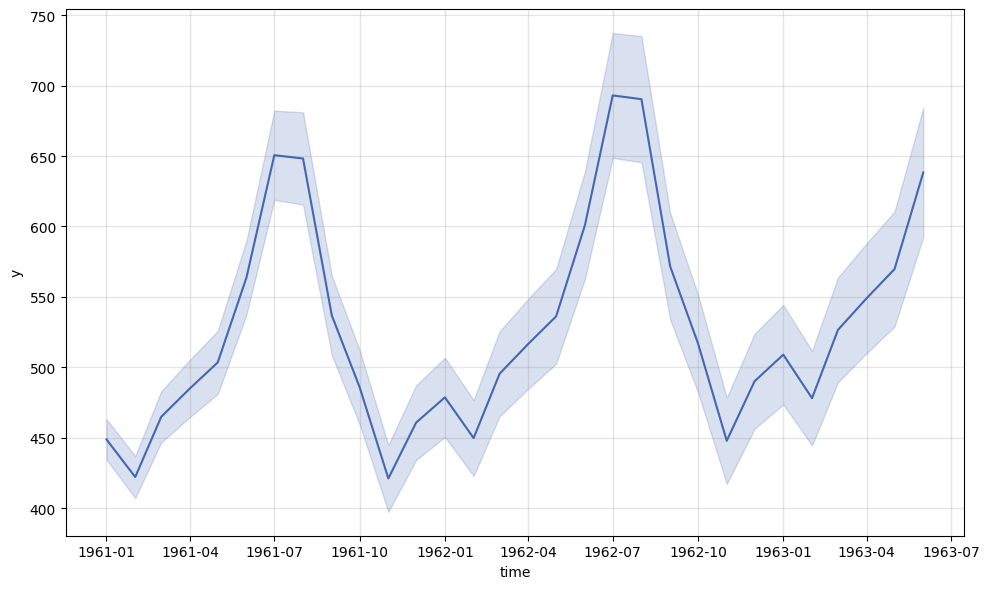

In [11]:
# create `KatsEnsembleParam` with detailed configurations 
KatsEnsembleParamBG = {
    "models": model_params,
    "aggregation": "bates&gates",
    "seasonality_length": 12,
    "decomposition_method": "multiplicative",
}

# create `KatsEnsemble` model
mBG = KatsEnsemble(
    data=air_passengers_ts, 
    params=KatsEnsembleParamBG
    )

# fit and predict
mBG.fit()

# predict for the next 30 steps
fcstBG = mBG.predict(steps=30)

# aggregate individual model results
mBG.aggregate()

# plot to visualize
mBG.plot()

## Comparation

In [21]:
# print(fcstM.fcst_df)
# print(fcstBG.fcst_df)

pred_dt = pd.concat([fcstM.fcst_df, fcstBG.fcst_df], axis=1)
pred_dt

help(fcstM)


Help on KatsEnsemble in module kats.models.ensemble.kats_ensemble object:

class KatsEnsemble(kats.models.model.Model)
 |  KatsEnsemble(data: 'TimeSeriesData', params: 'Dict[str, Any]') -> 'None'
 |  
 |  Decomposition based ensemble model in Kats
 |  This is the holistic ensembling class based on decomposition when seasonality presents
 |  
 |  Method resolution order:
 |      KatsEnsemble
 |      kats.models.model.Model
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data: 'TimeSeriesData', params: 'Dict[str, Any]') -> 'None'
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  aggregate(self) -> 'pd.DataFrame'
 |      Aggregate the results from predict method
 |      
 |      Args:
 |          None
 |      
 |      Returns:
 |          final results in pd.DataFrame
 |  
 |  backTestExecutor(self, err_method: 'str') -> 'Dict[str, float]'
 |      wrapper for back test executor
 |      
 |      services wh